L’exercice proposé ci-dessous est basé sur un problème de recalage de modèle à partir de mesures de rigidités transversales pour des enveloppes poids lourd. Les données sont mises à disposition dans les fichiers « 315 80 R 22.5.txt, 385 55 R 22.5.txt, 495 45 R 22.5.txt » avec 3 colonnes : 
- Charge (noté $Fz$) en Newton,
- Pression (noté $P$) en Bar,
- Rigidité (noté $Dz$) en N/°. 

Les coefficients à optimiser sont notés $a1, a2, a3, a4$ et $a5$. Le modèle à ajuster est le suivant :

$ \displaystyle Dz = (a1 \times P + a2) \times \sin \left(a3 \times \arctan{\left(\frac{Fz}{a4 \times P + a5}\right)} \right)$

Cet exercice est séparé en dex parties. La première consiste à résoudre le problème d'identification de paramètres en utilisant des outils classiques d'optimisation. La seconde vise à trouver les solutions via une approche d'optimisation bayesienne.

## Identification par Optimisation Classique

### Chargement des Données

Veuillez tout d'abord charger les mesures de rigidités de dérive contenues dans le fichier " 315 80 R 22.5.txt".

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg as LA
from scipy.optimize import leastsq as LB
import matplotlib.pyplot as plt

%matplotlib notebook

#chemin = C:\Users\perra\Documents\Cours Polytech 5A\Michelin\Projet\OptimisationBayesienne 
chemin = "315 80 R 22.5.txt"
mat = np.loadtxt(chemin)
mat
z = mat[:,0]   # N
p  = mat[:,1]   # Bar
dz = mat[:,2]   # N/°

Ces mesures correspondents à des valeurs de rigidités de dérive pour trois niveaux de pression 7, 8.5 et 9.5 bars. Chaque palier de pression comporte 7 points de mesure.
Afficher les mesures $Dz(Fz)$ pour chaque palier de pression

In [2]:
# Affichage des Mesures 

z1=z[:7]
z2=z[7:14]
z3=z[14:21]

p1=np.array(sorted(p[:7]))
p2=np.array(sorted(p[7:14]))
p3=np.array(sorted(p[14:21]))

dz1=np.array(sorted(dz[:7]))
dz2=np.array(sorted(dz[7:14]))
dz3=np.array(sorted(dz[14:21]))

### Afiichage de Dz en fonction de Z

<IPython.core.display.Javascript object>


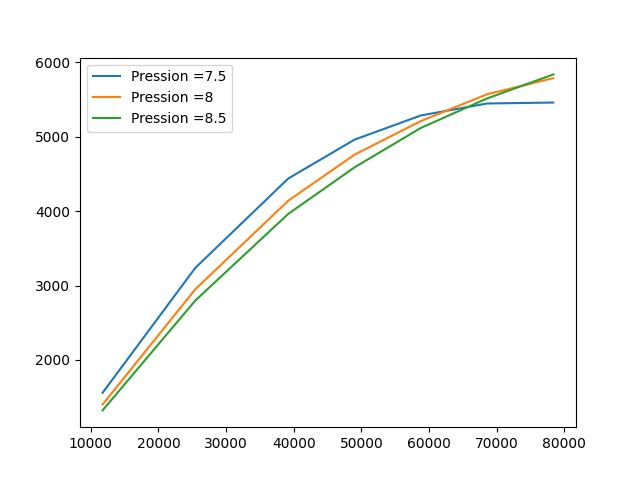

In [3]:
plt.plot(z1,dz1, label='Pression =7.5')
plt.plot(z2,dz2,label='Pression =8')
plt.plot(z3,dz3,label='Pression =8.5')
plt.legend()
plt.savefig("dz(fz)")

In [4]:
plt.close()

### Enuite on trace z en fonction de p pour essayer de déterminer les coefficients

<IPython.core.display.Javascript object>


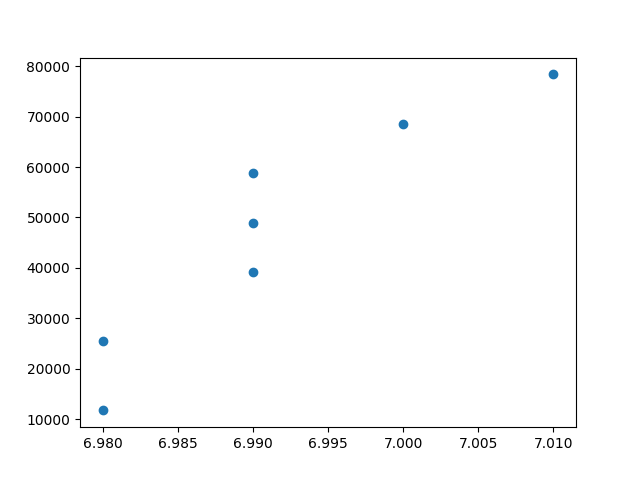

In [5]:
plt.scatter(p1,z1)
plt.savefig("ex1_1")

In [6]:
plt.close()

<IPython.core.display.Javascript object>


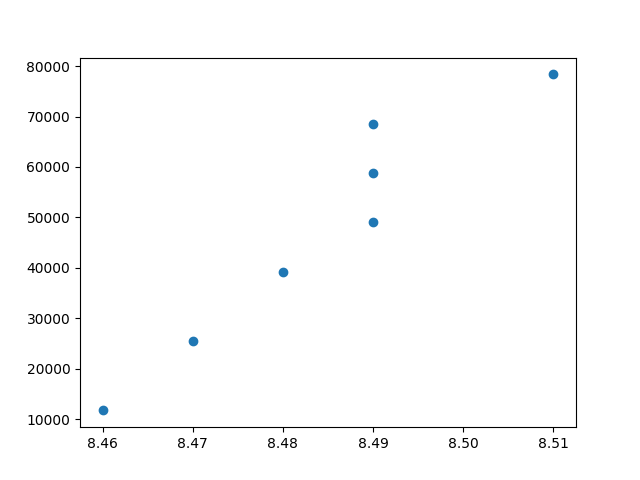

In [7]:
plt.scatter(p2,z2)
plt.savefig("ex1_2")

In [8]:
plt.close()

<IPython.core.display.Javascript object>


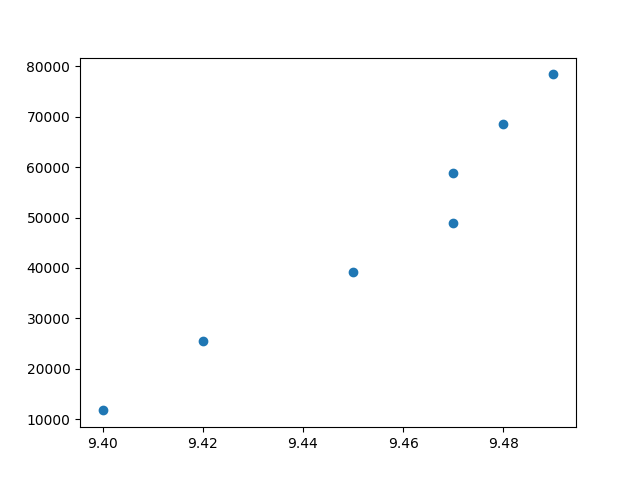

In [9]:
plt.scatter(p3,z3)
plt.savefig("ex1_3")

In [10]:
plt.close()

In [11]:
print(z1)
print(p1)
print(dz1)

[11736. 25447. 39179. 48986. 58788. 68591. 78373.]
[6.98 6.98 6.99 6.99 6.99 7.   7.01]
[1557.64 3237.7  4438.22 4961.65 5287.09 5448.14 5460.77]


In [12]:
print(z1)
print(z2)
print(z3)

[11736. 25447. 39179. 48986. 58788. 68591. 78373.]
[11730. 25454. 39178. 49003. 58799. 68603. 78363.]
[11734. 25463. 39198. 49004. 58790. 68606. 78402.]


On remarque ici que dans p1 on a plusieurs fois les même valeurs donc ona décidé de prendre une seul valeurs a chaque fois
Se qui nous donne les liste p4, z4 et dz4

In [13]:
print(p1)
p4=[p1[0],p1[2],p1[5],p1[6]]
z4=[z1[0],z1[2],z1[5],z1[6]]
dz4=[dz1[0],dz1[2],dz1[5],dz1[6]]
print(p4)
print(z4)

[6.98 6.98 6.99 6.99 6.99 7.   7.01]
[6.98, 6.99, 7.0, 7.01]
[11736.0, 39179.0, 68591.0, 78373.0]


<IPython.core.display.Javascript object>


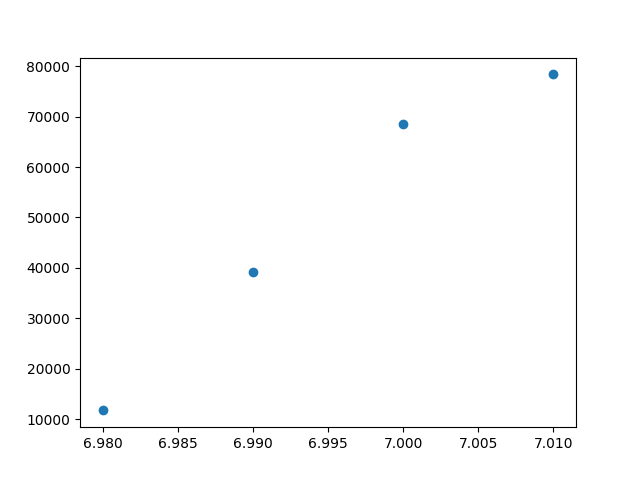

In [14]:
plt.scatter(p4,z4)
plt.savefig("ex1_4")

In [15]:
plt.close()

### Estimation des Valeurs Initiales

L’exercice est un problème d’optimisation continue, non linéaire et sans contrainte. Il est donc nécessaire d'initialiser les paramètres afin de pouvoir lancer un algorithme d'optimisation type recherche linéaire ou région de confiance.

Comment, à votre avis, peut-on essayer d’estimer les coefficients du modèle à partir des mesures ? Pour vous aider, n’oubliez pas que la fonction sinus est bornée. De plus, cadeau, je vous conseille d’approcher a3 par la valeur 2. Il vous reste seulement 4 petits coef à trouver…

Second conseil, le modèle peut également s’écrire sous la forme suivante, idéale quand on connaît déjà $a1, a2$ et $a3$, avec quelques restrictions cependant sur le domaine de définition des fonctions $1/x$, $\arctan$ et $\arcsin$:

$ \displaystyle a4 \times P + a5 = \frac{Fz}{\tan \left(\frac{1}{3} \times \arcsin\left(\frac{Dz}{a1 \times P + a2} \right) \right)}$

#### Recherche de a1 et a2

on a remarquer en trançant p4 en fonction de z4 que l'on obtenais une droite du coup on a décider de calculer a1 et a2 en 
prennant a1 comme le vecteur directeur de la droite et a2 comme l'odonné a l'originie

In [16]:
# Estimation initiale de a1

a1=(z4[0]-z4[1])/(p4[0]-p4[1])
a1


2744300.0000000587

In [17]:
# Estimation initiale de a1
a2=z4[0]-a1*p4[0]
a2

-19143478.00000041

In [18]:
a2=z4[0]-a1*p4[0]
a2

-19143478.00000041

#### Recherche de a4 et a5

Maintenant que l'on a a1 et a2 on peut utiliser la formule précédement donner pour essayer de trouver a4 et a5 

In [19]:
def f(P,Fz,Dz):
    arg_arcsin = Dz / (a1 * P + a2)

    # Calcul de l'arc sinus
    arcsin_result = np.arcsin(arg_arcsin)

    # Calcul de l'argument de la tangente
    arg_tan = (1 / 3) * arcsin_result

    # Calcul de la tangente
    tan_result = np.tan(arg_tan)

    # Calcul final de l'expression
    result = Fz / tan_result
    return result

In [20]:
data45=[]
for i in range(len(p4)):
    data45.append(f(p4[i],z4[i],dz4[i]))

In [21]:
data45

[264317.4551483314, 1034852.6245760171, 2512839.3452871474, 4047281.2302307207]

<IPython.core.display.Javascript object>


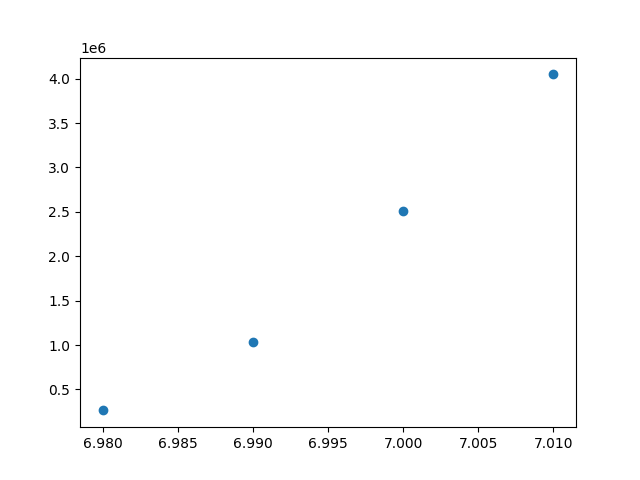

In [22]:
plt.scatter(p4,data45)
plt.savefig("ex1_5")

In [23]:
plt.close()

Comme l'indique la formule les valeurs que l'on a dans data45 suit une droite de coefficient directeur a4 et d'ordonnée a 
l'origine a5 donc on vas calculer comme on la fait précédement pour a1 et a2 en utilisant les valeurs de data45

In [24]:
# Estimation de a4

a4=(data45[0]-data45[1])/(p4[0]-p4[1])
a4

77053516.94277021

In [25]:
# Estimation de a5

a5=data45[0]-a4*p4[0]
a5

-537569230.8053877

#### Récapitulatif des valeurs trouver pour les paramètre

In [26]:
#a1=2744300.0000000587
#a2=-19143478.00000041
a3=2
#a4=77053516.94277021
#a5=-537569230.8053877

In [27]:
param=[a1,a2,a3,a4,a5]
param

[2744300.0000000587,
 -19143478.00000041,
 2,
 77053516.94277021,
 -537569230.8053877]

Superposer les courbes de mesures et de prédictions obtenues avec l'initialisation trouvée. Que constatez-vous?

In [28]:
# Fonction permettant de simuler le modèle
# Entrées: paramètres du modèle
# Return: la valeur de Dz 

def Fonction_DZ(parametres, P, Fz):
    DZ=[]
    a1, a2, a3, a4, a5 = parametres
    for i in range(P.shape[0]):
        Valeur=(a1 * P[i] + a2) * np.sin(a3 * np.arctan(Fz[i] / (a4 * P[i] + a5)))
        DZ.append(Valeur)
    return DZ


In [29]:
# On vas calculer pour les 3 pressions les valeurs de DZ

Pour le niveau de pression = 7.5

In [30]:
DZ1_pred=Fonction_DZ(param,p1,z1)
DZ1_pred

[1040.1333001803005,
 2238.9995829159657,
 2962.3484213714305,
 3700.8780365346565,
 4437.049174881186,
 5054.961779831051,
 5718.601296755186]

Pour le niveau de pression = 8

In [31]:
DZ2_pred=Fonction_DZ(param,p2,z2)
DZ2_pred

[836.0163788319983,
 1814.1414199040244,
 2792.2589842766347,
 3492.4843003460273,
 4190.65298919194,
 4889.391666729592,
 5584.953584259393]

Pour le niveau de pression = 8,5

In [32]:
DZ3_pred=Fonction_DZ(param,p3,z3)
DZ3_pred

[836.1165383365069,
 1814.3833546861842,
 2793.0683108923363,
 3491.788890523085,
 4189.09197223595,
 4888.526023758913,
 5586.53306893166]

In [33]:
# Affichage de la superposition mesures/prédictions

Pour la pression de 7.5

<IPython.core.display.Javascript object>


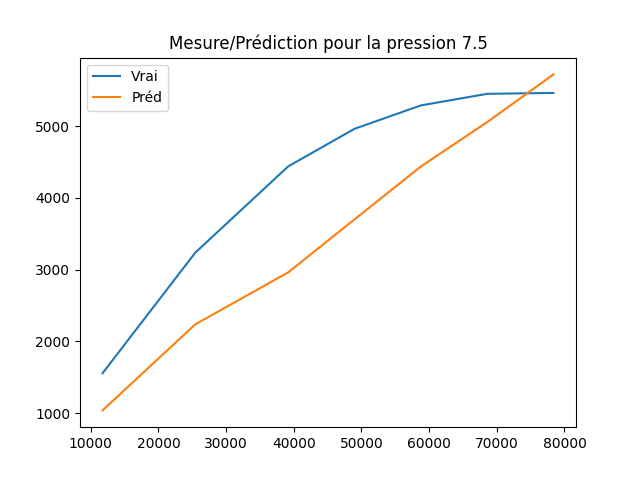

In [34]:
plt.plot(z1,dz1, label='Vrai')
plt.plot(z1,DZ1_pred,label='Préd')
plt.title("Mesure/Prédiction pour la pression 7.5")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_7_5")

In [35]:
plt.close()

Pour la pression de 8

<IPython.core.display.Javascript object>


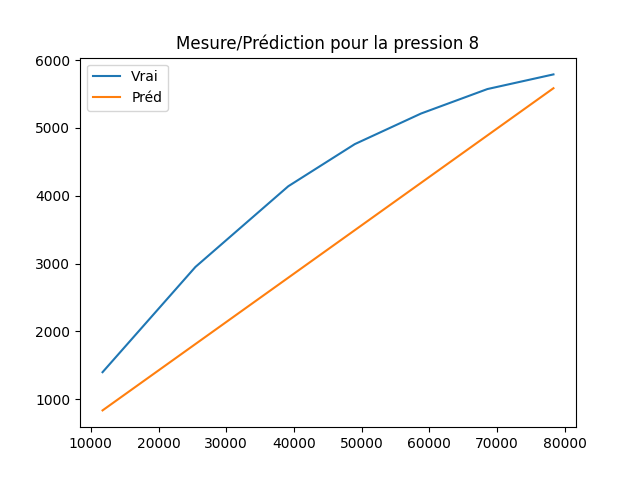

In [36]:
plt.plot(z2,dz2, label='Vrai')
plt.plot(z2,DZ2_pred,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8")

In [37]:
plt.close()

Pour la pression = 8.5

<IPython.core.display.Javascript object>


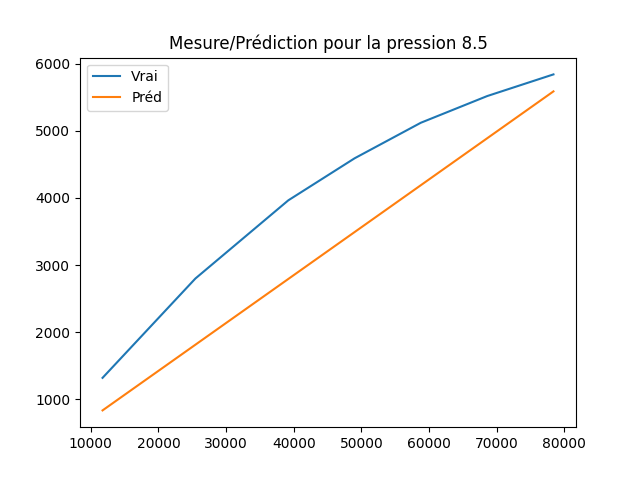

In [38]:
plt.plot(z3,dz3, label='Vrai')
plt.plot(z3,DZ3_pred,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8.5")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_5")

In [39]:
plt.close()

### Fine Tuning des valeurs

Dans le but d'affiner les valeurs obtenues à l'issue de la phase d'initialisation, il est nécessaire de faire appel à un algorithme d'optimisation non linéaire.

En l'occurence, il s'agit d'un problème de curve fitting. 

Quel critère est-il pertinent de considérer? 

Quel type d'algorithme peut-on mettre en oeuvre? 

Implémenter l'optimisation des valeurs des coefficients.

On va mettre en place un algo des moindre carré pour essayer d'obtenir les paramètres optimaux

In [40]:
# Fonction permettant de calculer la fonction coût
# Entrées: paramètres à optimiser
# Return: la valeur du critère à optimiser 

def cost_function(params,P,Fz,Dz):
    predicted_Dz = np.array(Fonction_DZ(params,P,Fz))
    Diff = predicted_Dz - Dz
    return Diff

In [41]:
Fz = np.concatenate((z1, z2, z3), axis=0)
Fz

array([11736., 25447., 39179., 48986., 58788., 68591., 78373., 11730.,
       25454., 39178., 49003., 58799., 68603., 78363., 11734., 25463.,
       39198., 49004., 58790., 68606., 78402.])

In [42]:
P= np.concatenate((p1, p2,p3), axis=0)
P

array([6.98, 6.98, 6.99, 6.99, 6.99, 7.  , 7.01, 8.46, 8.47, 8.48, 8.49,
       8.49, 8.49, 8.51, 9.4 , 9.42, 9.45, 9.47, 9.47, 9.48, 9.49])

In [43]:
Dz= np.concatenate((dz1, dz2, dz3), axis=0)
Dz

array([1557.64, 3237.7 , 4438.22, 4961.65, 5287.09, 5448.14, 5460.77,
       1399.18, 2950.42, 4140.05, 4760.91, 5212.09, 5572.68, 5788.68,
       1320.73, 2799.98, 3963.98, 4590.18, 5119.2 , 5516.78, 5839.33])

In [44]:
# Optimisation des paramètres
parametres_optimaux,_= LB(cost_function, param, args=(P, Fz, Dz))
parametres_optimaux

C:\Users\perra\anaconda3\envs\Michelin\lib\site-packages\scipy\optimize\minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


array([ 7.03051235e+06, -4.90515983e+07,  2.32994007e-01,  1.97720298e+07,
       -1.37974866e+08])

Superposer les courbes de mesures et de prédictions obtenues avec les valeurs finales trouvées. A-t-on améliorer la qualité de prédiction du modèle par rapport à la phase d'initialisation? Comment peut-on le quantifier?

In [45]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres

Pour le niveau de pression = 7.5

In [46]:
DZ1_pred_opt=Fonction_DZ(parametres_optimaux,p1,z1)
DZ1_pred_opt

[1658.2724834079402,
 3195.1143579946797,
 3578.525271083519,
 4450.419450224799,
 5306.6851967863995,
 5977.7476577386715,
 6728.674237013597]

<IPython.core.display.Javascript object>


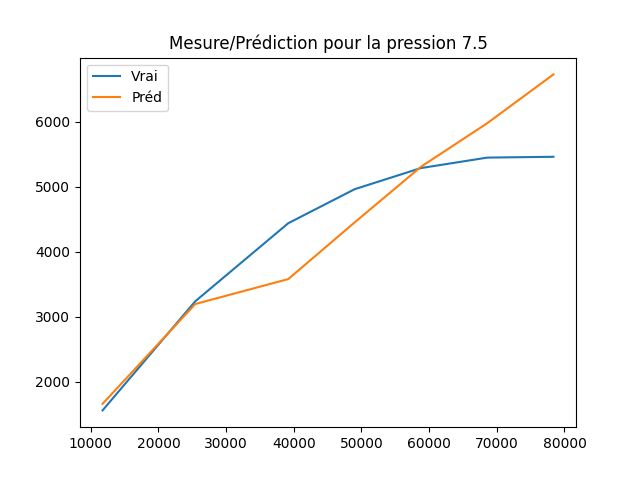

In [47]:
plt.plot(z1,dz1, label='Vrai')
plt.plot(z1,DZ1_pred_opt,label='Préd')
plt.title("Mesure/Prédiction pour la pression 7.5")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_7_5_optimaux")

In [48]:
plt.close()

Pour le niveau de pression = 8

In [49]:
DZ2_pred_opt=Fonction_DZ(parametres_optimaux,p2,z2)
DZ2_pred_opt

[972.673216106012,
 2110.679512608715,
 3248.6715121307384,
 4063.3434433448174,
 4875.6287254286435,
 5688.576291100015,
 6497.8001656883625]

<IPython.core.display.Javascript object>


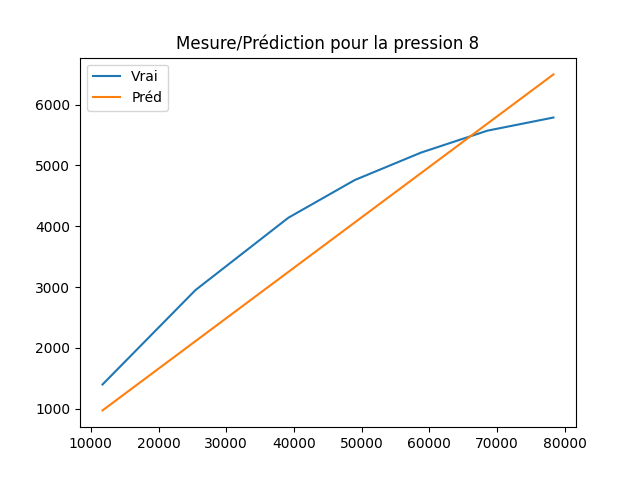

In [50]:
plt.plot(z2,dz2, label='Vrai')
plt.plot(z2,DZ2_pred_opt,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_optimaux")

In [51]:
plt.close()

Pour le niveau de pression = 8.5

In [52]:
DZ3_pred_opt=Fonction_DZ(parametres_optimaux,p3,z3)
DZ3_pred_opt

[972.6672360335513,
 2110.696519373403,
 3249.2057793460567,
 4062.0280589704125,
 4873.206147495618,
 5686.8585287435235,
 6498.849300902253]

<IPython.core.display.Javascript object>


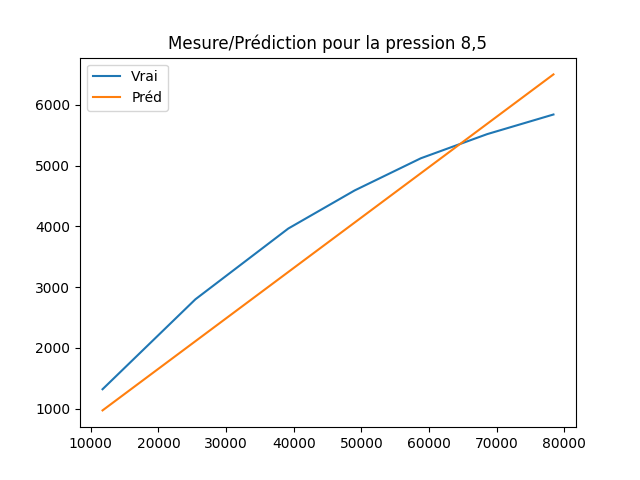

In [53]:
plt.plot(z3,dz3, label='Vrai')
plt.plot(z3,DZ3_pred_opt,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8,5")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_5_optimaux")

In [54]:
plt.close()

On remarque que l'on a pas des très bonne prédiction donc cela peux venir de deux chose :
Soit c'est l'algo d'optimisation qui est mauvais  
Soit c'est l'initialisation  
Et on vas se tourner sur la deuxième option  

### Nouveau test pour initialisé les paramètres

<IPython.core.display.Javascript object>


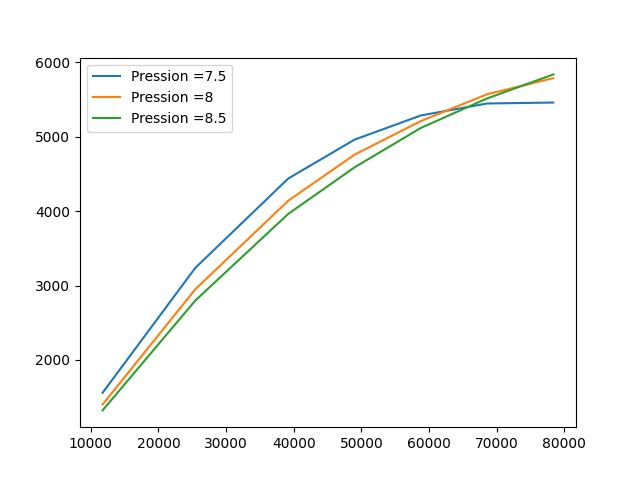

In [55]:
plt.plot(z1,dz1, label='Pression =7.5')
plt.plot(z2,dz2,label='Pression =8')
plt.plot(z3,dz3,label='Pression =8.5')
plt.legend()
plt.savefig("dz(fz)")

In [56]:
plt.close()

En prennant le fait que le sinus est borné on vas avoir le modèle qui passe de ça :
$ \displaystyle Dz = (a1 \times P + a2) \times \sin \left(a3 \times \arctan{\left(\frac{Fz}{a4 \times P + a5}\right)} \right)$

A ça : $ \displaystyle Dz = (a1 \times P + a2) \times 1$

En regardans sur le graph au dessus pour avoir l'amplitude maximal on vas prendre pour chaque palier de pression le 
dz maximal et le P maximal

On trace dz en focntion de p pour chaque palier de pression pour voir a quoi ça ressemble

<IPython.core.display.Javascript object>


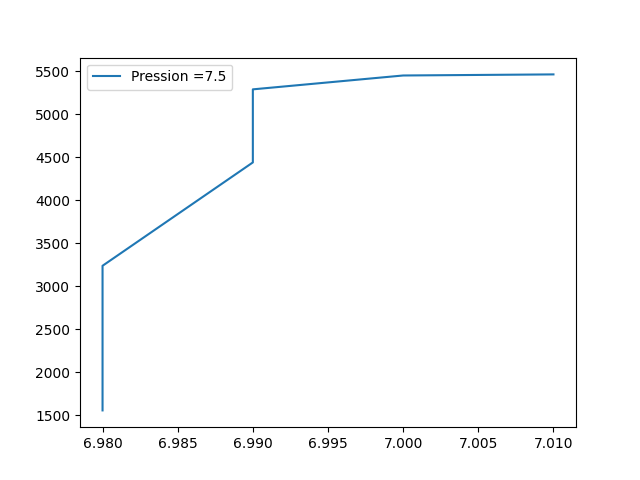

In [57]:
plt.plot(p1,dz1, label='Pression =7.5')
plt.legend()
plt.show()

In [58]:
plt.close()

<IPython.core.display.Javascript object>


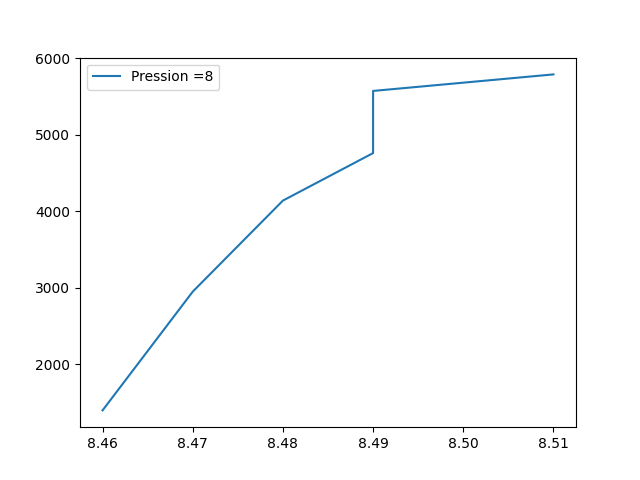

In [59]:
plt.plot(p2,dz2,label='Pression =8')
plt.legend()
plt.show()

In [60]:
plt.close()

<IPython.core.display.Javascript object>


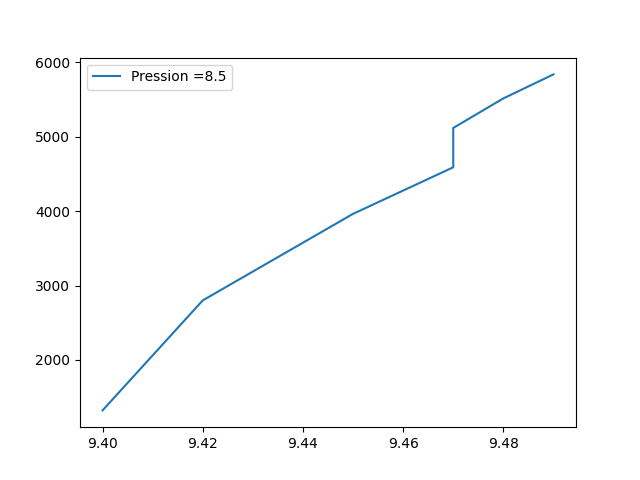

In [61]:
plt.plot(p3,dz3,label='Pression =8.5')
plt.legend()
plt.show()

In [62]:
plt.close()

On prend les max pour chaque palier de pression la pression max et le dz

In [63]:
P_max = [p1.max(),p2.max(),p3.max()]
dz_max = [dz1.max(),dz2.max(),dz3.max()]
fz_max = [z1.max(),z2.max(),z3.max()]

In [64]:
print(dz_max)
print(P_max)
print(fz_max)

[5460.77, 5788.68, 5839.33]
[7.01, 8.51, 9.49]
[78373.0, 78363.0, 78402.0]


On a donc comme système a résoudre :

In [65]:
# 5460.77 =  a1 * 7.01 + a2
# 5788.68 = a1 * 8.51 + a2
# 5839.33 = a1 * 9.49 + a2

Utilisons la résolution de gauss avec python

In [66]:
# Coefficients du système d'équations
coefficients = np.array([[7.01, 1],
                         [8.51, 1],
                         [9.49, 1]])

# Résultats des équations
results = np.array([5460.77, 5788.68, 5839.33])

# Utiliser la fonction np.linalg.lstsq pour résoudre le système avec une matrice non carré
solution = np.linalg.lstsq(coefficients, results, rcond=None)[0]
# On prend [0] la commande renvoie un tuple et le premier emplacement correspond au solution
a1, a2 = solution
print(f"a1 = {a1}, a2 = {a2}")


a1 = 158.1414836338767, a2 = 4377.887164772247


### Maintenant on vas essayer de trouver le coefficient a4 avec la formule déjà implémenter avant :

In [67]:
resultat=[]
resultat.append(f(P_max[0],fz_max[0],dz_max[0]))
resultat.append(f(P_max[2],fz_max[2],dz_max[2]))

# ici on prend pas le [1] car le arcsin ne vas pas marché pour cette valeurs

In [68]:
resultat

[146465.04009606983, 148766.62993041854]

On a donc comme système a résoudre :

In [69]:
# 146465.04009606983 = a4 * 7.01 + a5
# 148766.62993041854 = a4 * 9.49 + a5

Utilisons la résolution de gauss avec python

In [70]:
# Coefficients du système d'équations
coefficients = np.array([[7.01, 1],
                         [9.49, 1]])

# Résultats des équations
results = np.array([146465.04009606983, 148766.62993041854])

# Utiliser la fonction np.linalg.lstsq pour résoudre le système avec une matrice non carré
solution = np.linalg.lstsq(coefficients, results, rcond=None)[0]
# On prend [0] la commande renvoie un tuple et le premier emplacement correspond au solution
a4, a5 = solution
print(f"a4 = {a4}, a5 = {a5}")


a4 = 928.0604170761028, a5 = 139959.3365723664


In [71]:
# On a donc comme solution  
# a1 = 158.1414836338767, a2 = 4377.887164772247, a3=2, a4 = 928.0604170761028, a5 = 139959.3365723664

### Superposon les vrai courbe avec les prédiction pour ses premier paramètres

In [72]:
param_nouv=[158.1414836338767, 4377.887164772247, 2, 928.0604170761028, 139959.3365723664]

In [73]:
DZ1_pred_2=Fonction_DZ(param_nouv,p1,z1)
DZ1_pred_2

[873.0408516040471,
 1849.3160185274157,
 2737.9428199334793,
 3299.1604594727837,
 3791.3564900049196,
 4213.394823088864,
 4564.599129204186]

<IPython.core.display.Javascript object>


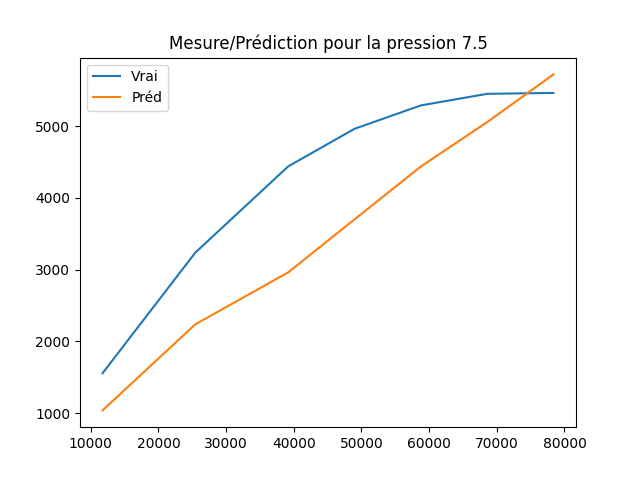

In [74]:
plt.plot(z1,dz1, label='Vrai')
plt.plot(z1,DZ1_pred,label='Préd')
plt.title("Mesure/Prédiction pour la pression 7.5")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_2_Pression_7_5")

In [75]:
plt.close()

In [76]:
DZ2_pred_2=Fonction_DZ(param_nouv,p2,z2)
DZ2_pred_2

[901.5085641242923,
 1912.304408328405,
 2832.3473659026304,
 3416.8691254145297,
 3928.882120371905,
 4368.422793428951,
 4736.5413830686875]

<IPython.core.display.Javascript object>


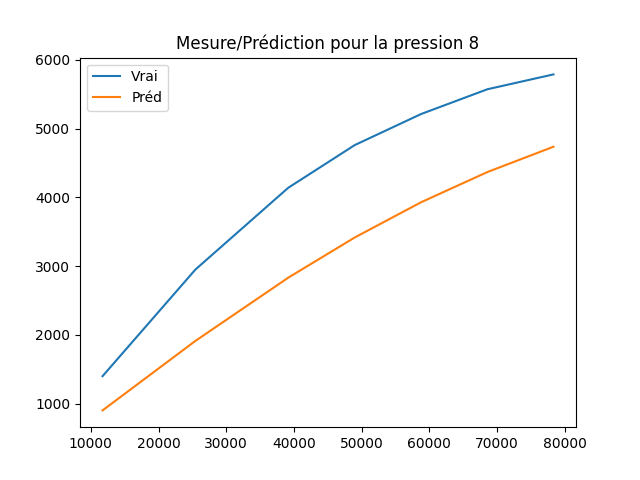

In [80]:
plt.plot(z2,dz2, label='Vrai')
plt.plot(z2,DZ2_pred_2,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_2_Pression_8")

In [81]:
plt.close()

In [82]:
DZ3_pred_2=Fonction_DZ(param_nouv,p3,z3)
DZ3_pred_2

[919.904593097189,
 1952.23307595942,
 2894.291854441386,
 3492.2519973665453,
 4016.889536432215,
 4470.139335501082,
 4849.373896764981]

<IPython.core.display.Javascript object>


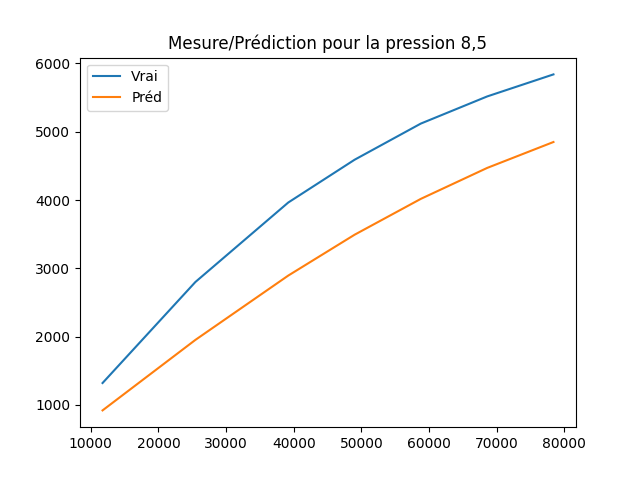

In [83]:
plt.plot(z3,dz3, label='Vrai')
plt.plot(z3,DZ3_pred_2,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8,5")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_2_Pression_8_5")

In [84]:
plt.close()

### On vas maintenant essayer d'optimiser ses paramètres :

In [85]:
# Optimisation des paramètres
parametres_optimaux_2,_= LB(cost_function, param_nouv, args=(P, Fz, Dz))
parametres_optimaux_2

array([ 2.39149639e+02,  3.80733518e+03,  2.08417994e+00,  1.20851722e+04,
       -3.27596129e+03])

### Trace des graphes avec les paramètre optimaux

Pour la pression 7.5

In [86]:
DZ1_pred_opt_2=Fonction_DZ(parametres_optimaux_2,p1,z1)
DZ1_pred_opt_2

[1616.3588496811735,
 3243.481737337019,
 4414.723618317932,
 4958.420833427344,
 5288.097588180084,
 5447.99243278828,
 5481.905332104025]

<IPython.core.display.Javascript object>


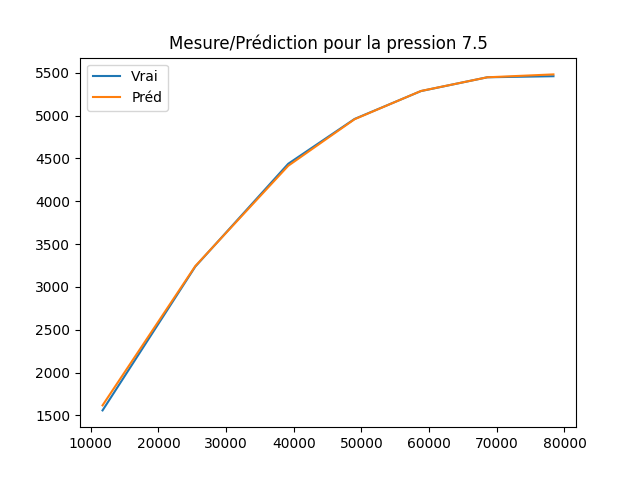

In [87]:
plt.plot(z1,dz1, label='Vrai')
plt.plot(z1,DZ1_pred_opt_2,label='Préd')
plt.title("Mesure/Prédiction pour la pression 7.5")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_7_5_optimaux_2")

In [88]:
plt.close()

Pour la pression 8

In [89]:
DZ2_pred_opt_2=Fonction_DZ(parametres_optimaux_2,p2,z2)
DZ2_pred_opt_2

[1419.2395343175356,
 2918.8547040852404,
 4119.971675910991,
 4766.105025084349,
 5239.14154543112,
 5557.613142144736,
 5746.939845554234]

<IPython.core.display.Javascript object>


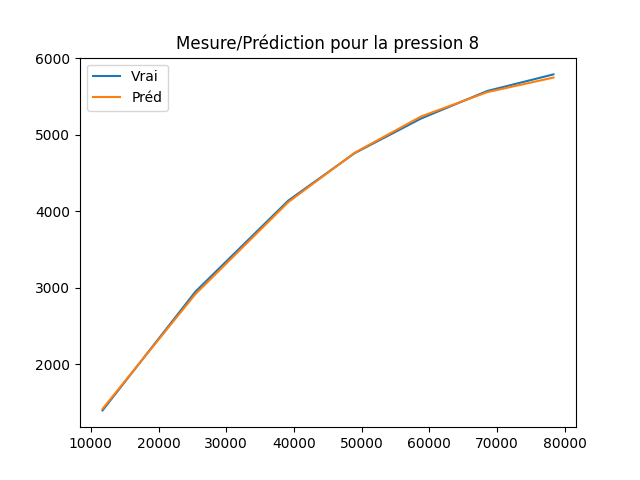

In [90]:
plt.plot(z2,dz2, label='Vrai')
plt.plot(z2,DZ2_pred_opt_2,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_optimaux_2")

In [91]:
plt.close()

Pour la pression 8.5

In [92]:
DZ3_pred_opt_2=Fonction_DZ(parametres_optimaux_2,p3,z3)
DZ3_pred_opt_2

[1326.4223871508857,
 2754.0160233839474,
 3945.3173850733083,
 4622.627268864976,
 5154.373716171827,
 5547.937730118835,
 5818.313566768766]

<IPython.core.display.Javascript object>


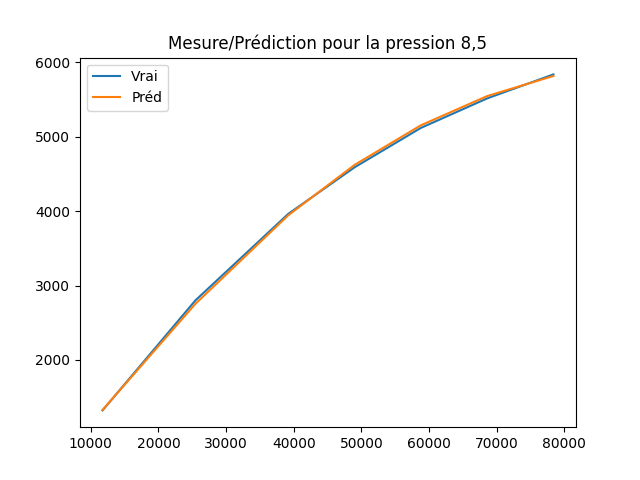

In [93]:
plt.plot(z3,dz3, label='Vrai')
plt.plot(z3,DZ3_pred_opt_2,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8,5")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_5_optimaux_2")

In [94]:
plt.close()

Pour conclure on vois que l'on a réussi a avoir une très bonne approximation des courbe et que l'on a trouver de très bon
paramètres donc c'était bien notre initialisation qui étais mauvaise

## Identification par Optimisation Bayesienne

Comme précisé plus haut, cette partie vise à résoudre le problème d'identification via une approche bayesienne. Pour ce faire, nous allons nous appuyer sur le package python scikit-optimize (https://scikit-optimize.github.io/stable/).

In [95]:
from skopt import gp_minimize
from skopt.plots import plot_gaussian_process, plot_convergence

### Premier Essai

Nous travaillons toujours avec la même fonction objectif utilisée dans la première partie du TP. On va considérer de plus les bornes suivantes:
- $200 \leq a1 \leq 300$
- $3000 \leq a2 \leq 4500$
- $1 \leq a3 \leq 3$
- $1e4 \leq a4 \leq 2e4$
- $-5e3 \leq a5 \leq -2e3$

La fonction d'acquisition qui sera utilisée dans un premier temps est l'amélioration espérée (Expected Improvement). Nous fixerons le nombre d'appels à la fonction coût originale à 100. Enfin, on utilise un plan de type LHS avec 50 points pour construire le modèle de krigeage avant la permière minimisation de la fonction d'acquisition.

A l'aide de la documentation du package scikit-optimize, implémenter cette première tentative d'optimisation bayesienne et visualiser le graphe de convergence. A-t-on le même niveau de convergence qu'observé dans la première section du TP? Comment pourrait-on améliorer la convergence?

In [96]:
# Fonction permettant de calculer la fonction coût au format attendu par scikit-optimize (donc elle doit prendre qu'un paramètre)
# Entrées: paramètres à optimiser
# Return: la valeur du critère à optimiser 
# Définir la fonction coût wrapper
def wrapper(params):
    a1, a2, a3, a4, a5 = params
    result = cost_function([a1, a2, a3, a4, a5], p, z, dz)
    return np.sum(result**2) 


In [97]:
# Définition des bornes
Bornes = [(200, 300), (3000, 4500), (1, 3), (1e4, 2e4), (-5e3, -2e3)]

In [98]:
# Estimation des paramètres par optimisation bayesienne

result_1 = gp_minimize(wrapper, Bornes, acq_func='EI', n_calls=100, n_random_starts=50,random_state=42)


C:\Users\perra\anaconda3\envs\Michelin\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\perra\anaconda3\envs\Michelin\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\perra\anaconda3\envs\Michelin\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\perra\anaconda3\envs\Michelin\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\perra\anaconda3\envs\Michelin\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point befor

<IPython.core.display.Javascript object>


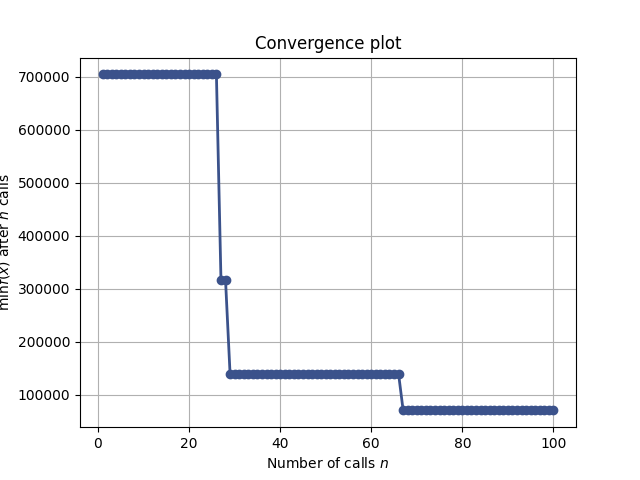

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

In [99]:
# Affichage de l'évolution de la fonction coût au fil des itérations via la fonction "plot_convergence" de scikit-optimize

plot_convergence(result_1)

In [100]:
#plot_gaussian_process(result_1)
# marche pas car on a 5 paramètre a optimiser et ça c'est quand on veux regarder que pour un seul

In [101]:
plt.close()

In [102]:
optimal_params = result_1.x

In [103]:
optimal_params

[200, 4073, 3, 17575.280368435888, -2000.0]

In [104]:
### Voir les courbes si cela a changer

Pour la pression 7.5

In [105]:
DZ1_pred_opt_bay=Fonction_DZ(optimal_params,p1,z1)
DZ1_pred_opt_bay

[1568.290622246474,
 3193.1512560660453,
 4419.772386219511,
 5005.522807106081,
 5347.88052617038,
 5471.426553392122,
 5412.53121320403]

<IPython.core.display.Javascript object>


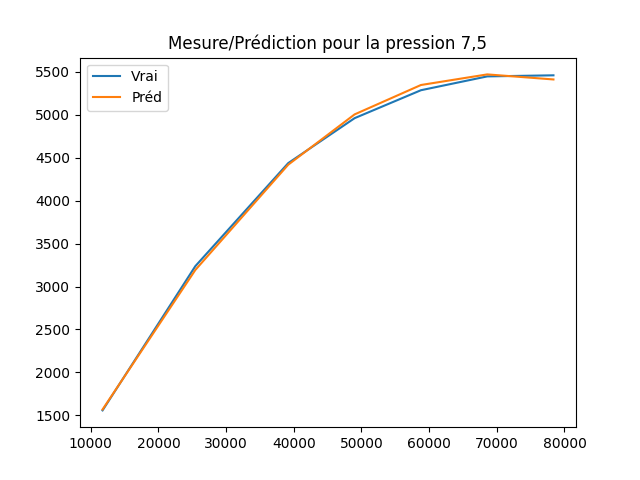

In [106]:
plt.plot(z1,dz1, label='Vrai')
plt.plot(z1,DZ1_pred_opt_bay,label='Préd')
plt.title("Mesure/Prédiction pour la pression 7,5 (EI_100_50)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_7_5_Bay (EI_100_50)")

In [107]:
plt.close()

Pour la pression = 8

In [108]:
DZ2_pred_opt_bay=Fonction_DZ(optimal_params,p2,z2)
DZ2_pred_opt_bay

[1366.936000393652,
 2839.6494583279386,
 4062.1094537552476,
 4740.7473144522555,
 5243.715586405539,
 5573.25431342815,
 5742.409046843938]

<IPython.core.display.Javascript object>


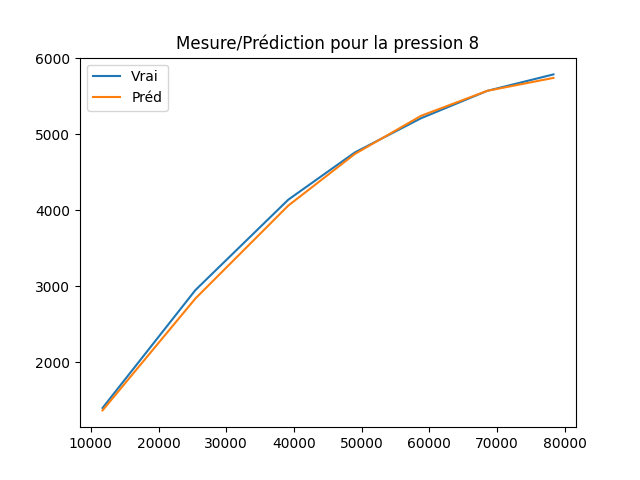

In [109]:
plt.plot(z2,dz2, label='Vrai')
plt.plot(z2,DZ2_pred_opt_bay,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8 (EI_100_50)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_Bay (EI_100_50)")

In [110]:
plt.close()

Pour la pression = 8.5

In [111]:
DZ3_pred_opt_bay=Fonction_DZ(optimal_params,p3,z3)
DZ3_pred_opt_bay

[1271.9063628575564,
 2662.3209307857937,
 3857.2960744838924,
 4556.469237297156,
 5115.74183763558,
 5529.457161140957,
 5801.889777280235]

<IPython.core.display.Javascript object>


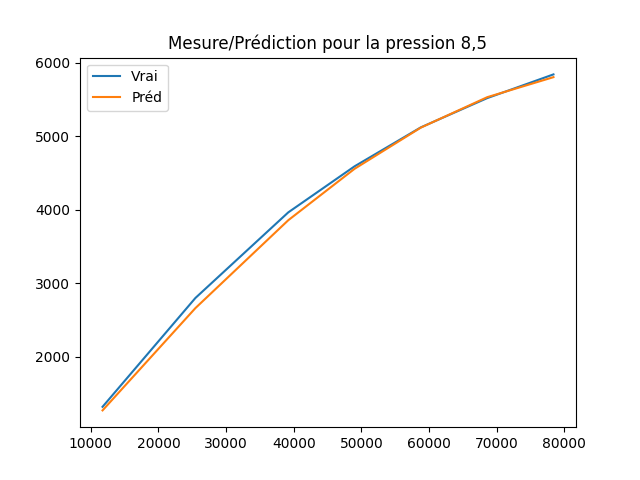

In [112]:
plt.plot(z3,dz3, label='Vrai')
plt.plot(z3,DZ3_pred_opt_bay,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8,5 (EI_100_50)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_5_Bay (EI_100_50)")

In [113]:
plt.close()

### Amélioration de la configuration de l'algorithme

Essayer différents nombres de points d'évaluation et les fonctions d'acquisition PI et LCB pour tenter d'améliorer le paramétrage de l'algorithme. A partir de l'analyse des graphiques de convergence et de fonctions d'acquisition, quelle est la configuration la plus efficiente?

In [114]:
# Tests et évaluation avec différentes options du solver

On utilise la fonction PI pour 50 point d'évaluation

In [115]:
result_2 = gp_minimize(wrapper, Bornes, acq_func='PI', n_calls=100, n_random_starts=50,random_state=42)

<IPython.core.display.Javascript object>


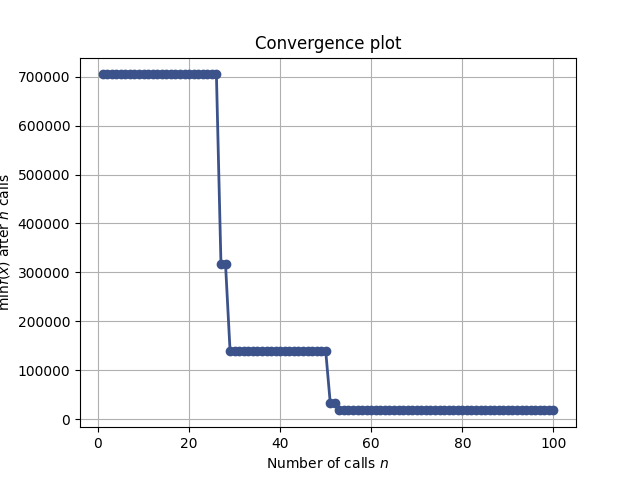

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

In [116]:
# Affichage de l'évolution de la fonction coût au fil des itérations via la fonction "plot_convergence" de scikit-optimize

plot_convergence(result_2)

In [117]:
plt.close()

In [132]:
# On obtient une meilleur convergence que EI donc on vas tester pour les prédiction pour les différent cas de pression

In [130]:
optimal_params_2 = result_2.x
optimal_params_2

[228, 3904, 2, 11497.225697382139, -2592.8159166110772]

In [131]:
DZ1_pred_opt_bay_2=Fonction_DZ(optimal_params_2,p1,z1)
DZ1_pred_opt_bay_2

[1623.9036519373071,
 3252.2894204268537,
 4417.92321607229,
 4958.453868337043,
 5289.242688425442,
 5455.867245164957,
 5502.218304431659]

<IPython.core.display.Javascript object>


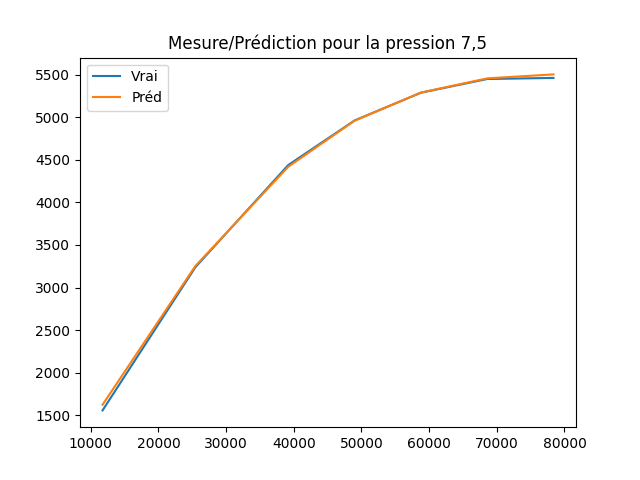

In [133]:
plt.plot(z1,dz1, label='Vrai')
plt.plot(z1,DZ1_pred_opt_bay_2,label='Préd')
plt.title("Mesure/Prédiction pour la pression 7,5 (PI_100_50)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_7_5_Bay_2 (PI_100_50)")

In [134]:
plt.close()

In [137]:
DZ2_pred_opt_bay_2=Fonction_DZ(optimal_params_2,p2,z2)
DZ2_pred_opt_bay_2

[1423.5260810547761,
 2923.093551676089,
 4117.847731081572,
 4757.88046899073,
 5226.153695153989,
 5543.040111943109,
 5734.746643374391]

<IPython.core.display.Javascript object>


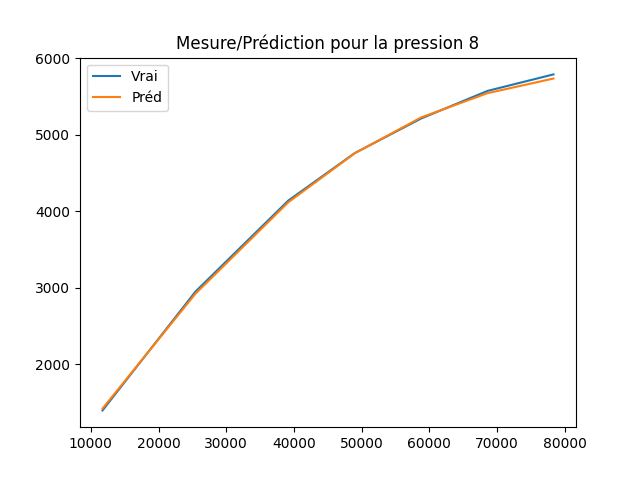

In [138]:
plt.plot(z2,dz2, label='Vrai')
plt.plot(z2,DZ2_pred_opt_bay_2,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8 (PI_100_50)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_Bay_2 (PI_100_50)")

In [139]:
plt.close()

In [140]:
DZ3_pred_opt_bay_2=Fonction_DZ(optimal_params_2,p3,z3)
DZ3_pred_opt_bay_2

[1328.9674857591658,
 2755.5415403086195,
 3940.2392758589863,
 4610.800559049067,
 5136.0476984215475,
 5524.8713373709315,
 5793.553460441223]

<IPython.core.display.Javascript object>


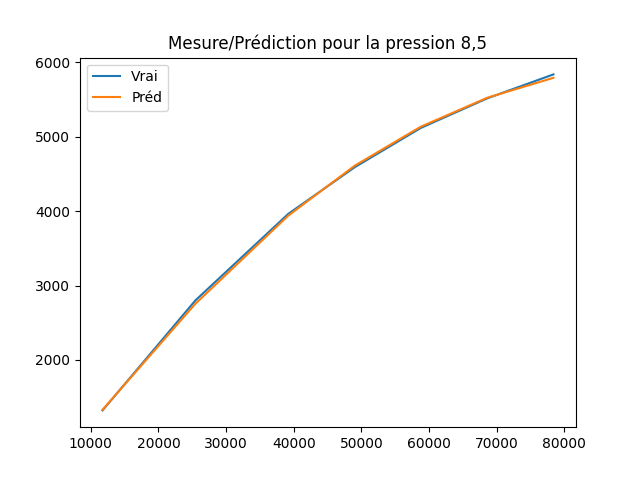

In [141]:
plt.plot(z3,dz3, label='Vrai')
plt.plot(z3,DZ3_pred_opt_bay_2,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8,5 (PI_100_50)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_5_Bay_2 (PI_100_50)")

In [142]:
plt.close()

In [143]:
# On remarque en effet qu'il y a de meilleur prédiction lorsque l'on utilise PI au lieu de EI dans l'opti bayésienne
# Avec les même paramêtre n_calls=100, n_random_starts=50,random_state=42)

On utilise la fonction PI pour 100 point d'évaluation

In [118]:
result_3 = gp_minimize(wrapper, Bornes, acq_func='PI', n_calls=100, n_random_starts=100,random_state=42)

<IPython.core.display.Javascript object>


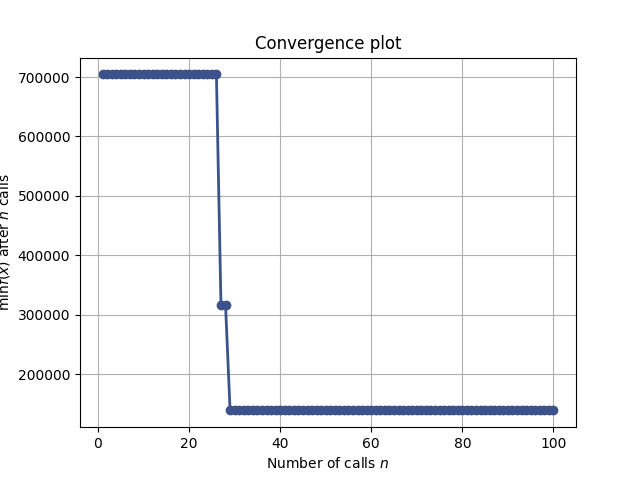

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

In [119]:
# Affichage de l'évolution de la fonction coût au fil des itérations via la fonction "plot_convergence" de scikit-optimize

plot_convergence(result_3)

In [120]:
plt.close()

In [ ]:
# Converge beaucoup moins bien que l'autre méthode donc le  n_random_starts=100 est trop grand car avec 50 on converge 
# plus vite

In [154]:
optimal_params_3 = result_3.x
optimal_params_3

[225, 4044, 2, 11480.869299533999, -2006.7785448531736]

In [155]:
DZ1_pred_opt_bay_3=Fonction_DZ(optimal_params_3,p1,z1)
DZ1_pred_opt_bay_3

[1649.5092886201116,
 3306.544094664386,
 4497.306739231532,
 5052.51983988838,
 5394.76217499957,
 5569.5607592598935,
 5621.245327568742]

<IPython.core.display.Javascript object>


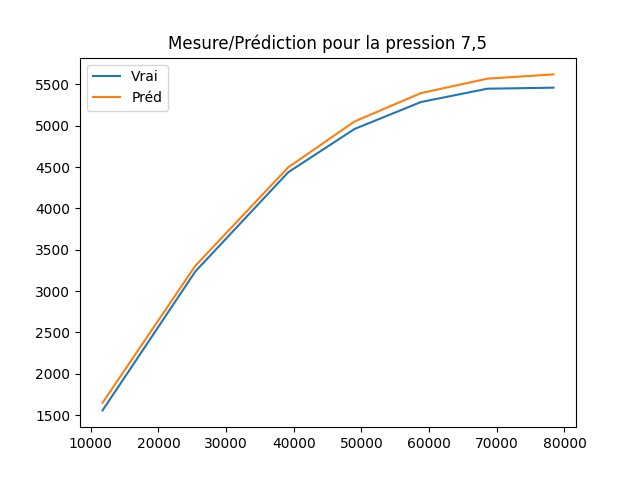

In [164]:
plt.plot(z1,dz1, label='Vrai')
plt.plot(z1,DZ1_pred_opt_bay_3,label='Préd')
plt.title("Mesure/Prédiction pour la pression 7,5 (PI_100_100)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_7_5_Bay_3 (PI_100_100)")

In [165]:
plt.close()

In [158]:
DZ2_pred_opt_bay_3=Fonction_DZ(optimal_params_3,p2,z2)
DZ2_pred_opt_bay_3

[1444.873375628681,
 2968.363843191297,
 4184.666513909368,
 4837.969313398654,
 5317.451751832552,
 5643.35138966907,
 5841.738569973482]

<IPython.core.display.Javascript object>


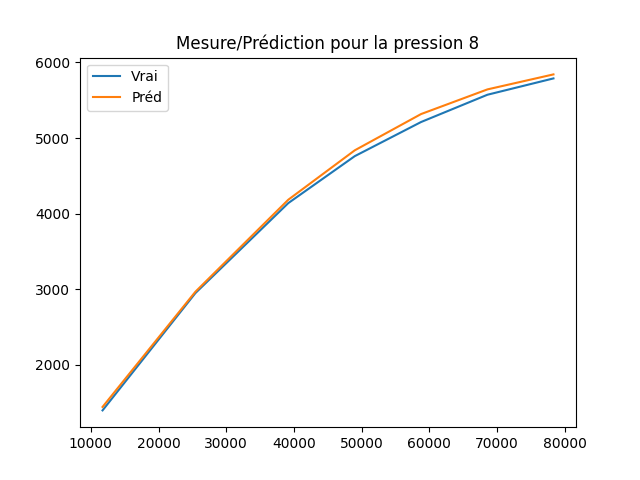

In [159]:
plt.plot(z2,dz2, label='Vrai')
plt.plot(z2,DZ2_pred_opt_bay_3,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8 (PI_100_100)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_Bay_3 (PI_100_100)")

In [160]:
plt.close()

In [161]:
DZ3_pred_opt_bay_3=Fonction_DZ(optimal_params_3,p3,z3)
DZ3_pred_opt_bay_3

[1348.1470594644634,
 2796.2445158487144,
 4000.4802973124315,
 4683.310326906043,
 5219.302832234105,
 5617.072591368859,
 5892.926683045823]

<IPython.core.display.Javascript object>


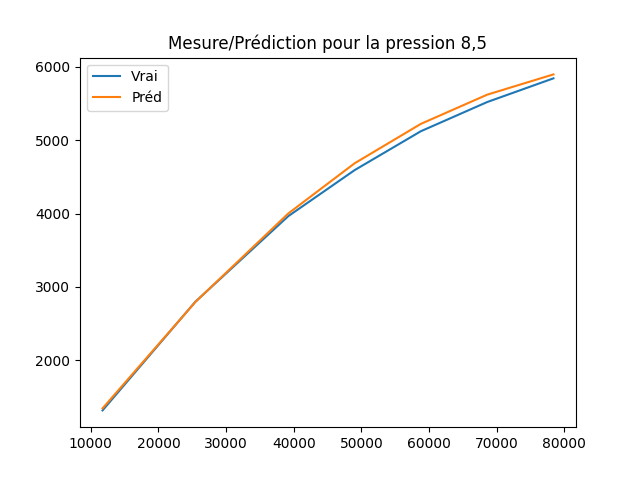

In [162]:
plt.plot(z3,dz3, label='Vrai')
plt.plot(z3,DZ3_pred_opt_bay_3,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8,5 (PI_100_100)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_5_Bay_3 (PI_100_100)")

In [163]:
plt.close()

In [ ]:
# On obient de moins bon résultat en augmentant n_random_starts a 100 alors qu'avec 50 on obtient de bien meilleur résultat

On utilise la fonction LCB pour 50 point d'évaluation

In [121]:
result_4 = gp_minimize(wrapper, Bornes, acq_func='LCB', n_calls=100, n_random_starts=50,random_state=42)

<IPython.core.display.Javascript object>


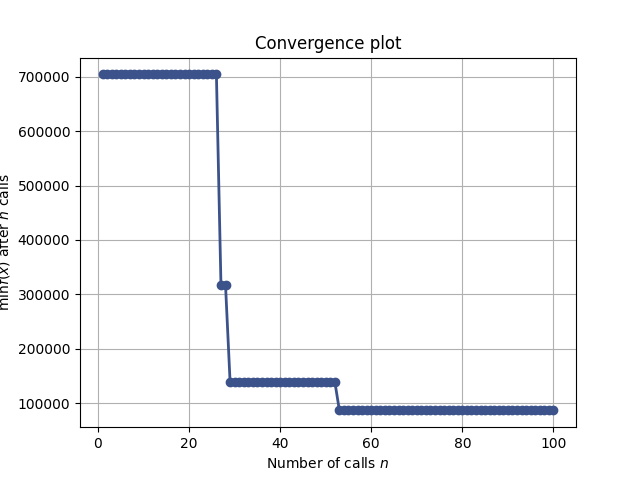

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

In [122]:
# Affichage de l'évolution de la fonction coût au fil des itérations via la fonction "plot_convergence" de scikit-optimize

plot_convergence(result_4)

In [123]:
plt.close()

In [176]:
optimal_params_4 = result_4.x
optimal_params_4

[200, 3985, 3, 17341.53782331361, -5000.0]

In [177]:
DZ1_pred_opt_bay_4=Fonction_DZ(optimal_params_4,p1,z1)
DZ1_pred_opt_bay_4

[1602.394818852316,
 3246.270004498453,
 4456.90699600795,
 5010.732976155167,
 5309.129785442177,
 5383.068482619599,
 5274.197778642896]

<IPython.core.display.Javascript object>


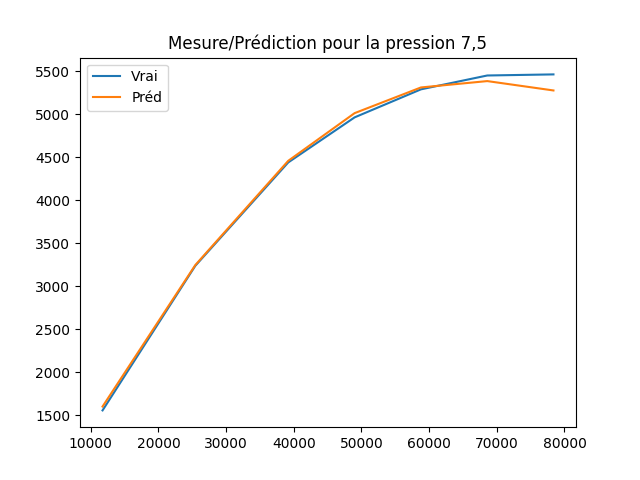

In [180]:
plt.plot(z1,dz1, label='Vrai')
plt.plot(z1,DZ1_pred_opt_bay_4,label='Préd')
plt.title("Mesure/Prédiction pour la pression 7,5 (LCB_100_50)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_7_5_Bay_4(LCB_100_50)")

In [181]:
plt.close()

In [182]:
DZ2_pred_opt_bay_4=Fonction_DZ(optimal_params_4,p2,z2)
DZ2_pred_opt_bay_4

[1392.1889626152933,
 2883.358566504305,
 4104.114410580464,
 4767.880062186543,
 5245.913653786153,
 5542.86091779624,
 5675.667599949545]

<IPython.core.display.Javascript object>


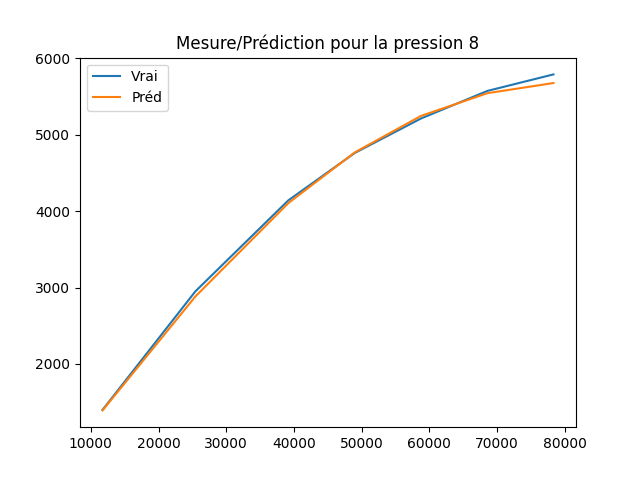

In [183]:
plt.plot(z2,dz2, label='Vrai')
plt.plot(z2,DZ2_pred_opt_bay_4,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8 (LCB_100_50)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_Bay_4(LCB_100_50)")

In [184]:
plt.close()

In [185]:
DZ3_pred_opt_bay_4=Fonction_DZ(optimal_params_4,p3,z3)
DZ3_pred_opt_bay_4

[1293.5041855476577,
 2701.275424048911,
 3898.8352634809034,
 4589.427438196729,
 5131.737934742094,
 5521.479443167091,
 5764.870705467255]

<IPython.core.display.Javascript object>


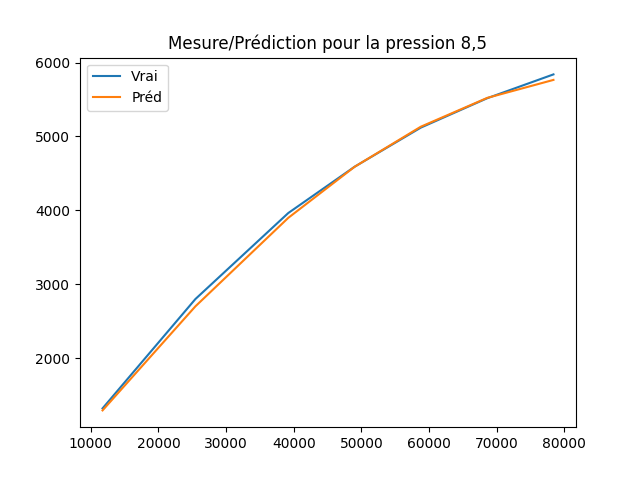

In [186]:
plt.plot(z3,dz3, label='Vrai')
plt.plot(z3,DZ3_pred_opt_bay_4,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8,5 (LCB_100_50)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_5_Bay_4(LCB_100_50)")

In [187]:
plt.close()

On utilise la fonction LCB pour 100 point d'évaluation

In [124]:
result_5 = gp_minimize(wrapper, Bornes, acq_func='LCB', n_calls=100, n_random_starts=100,random_state=42)

<IPython.core.display.Javascript object>


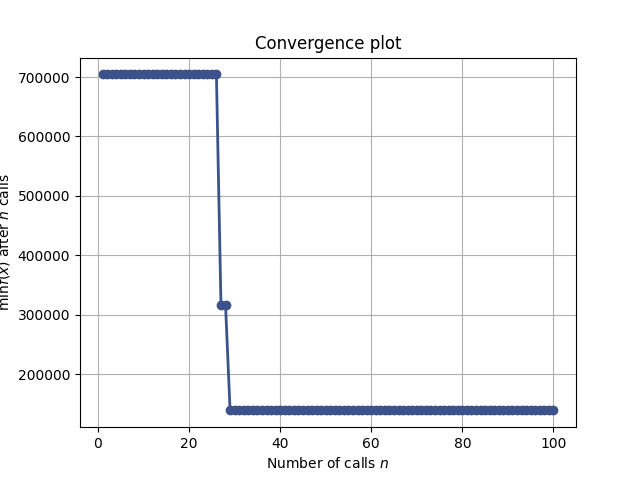

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

In [125]:
# Affichage de l'évolution de la fonction coût au fil des itérations via la fonction "plot_convergence" de scikit-optimize

plot_convergence(result_5)

In [126]:
plt.close()

In [166]:
optimal_params_5 = result_5.x
optimal_params_5

[225, 4044, 2, 11480.869299533999, -2006.7785448531736]

In [167]:
DZ1_pred_opt_bay_5=Fonction_DZ(optimal_params_5,p1,z1)
DZ1_pred_opt_bay_5

[1649.5092886201116,
 3306.544094664386,
 4497.306739231532,
 5052.51983988838,
 5394.76217499957,
 5569.5607592598935,
 5621.245327568742]

<IPython.core.display.Javascript object>


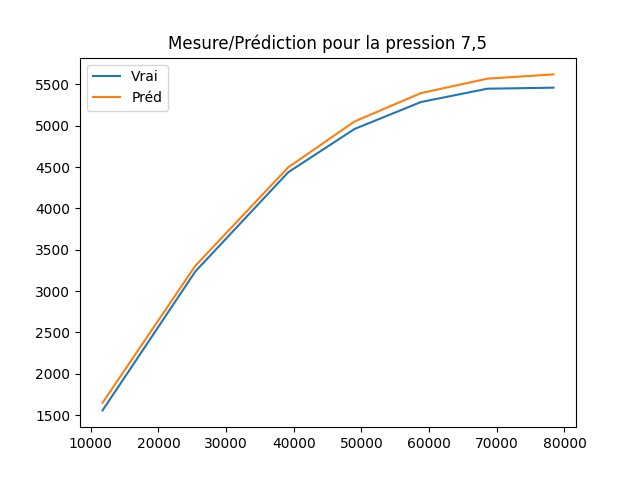

In [168]:
plt.plot(z1,dz1, label='Vrai')
plt.plot(z1,DZ1_pred_opt_bay_5,label='Préd')
plt.title("Mesure/Prédiction pour la pression 7,5 (LCB_100_100)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_7_5_Bay_5 (LCB_100_100)")

In [169]:
plt.close()

In [170]:
DZ2_pred_opt_bay_5=Fonction_DZ(optimal_params_5,p2,z2)
DZ2_pred_opt_bay_5

[1444.873375628681,
 2968.363843191297,
 4184.666513909368,
 4837.969313398654,
 5317.451751832552,
 5643.35138966907,
 5841.738569973482]

<IPython.core.display.Javascript object>


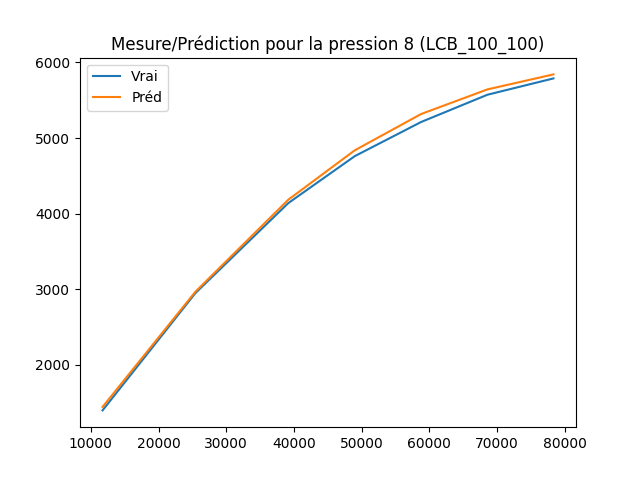

In [188]:
plt.plot(z2,dz2, label='Vrai')
plt.plot(z2,DZ2_pred_opt_bay_5,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8 (LCB_100_100)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_Bay_5 (LCB_100_100)")

In [189]:
plt.close()

In [173]:
DZ3_pred_opt_bay_5=Fonction_DZ(optimal_params_5,p3,z3)
DZ3_pred_opt_bay_5

[1348.1470594644634,
 2796.2445158487144,
 4000.4802973124315,
 4683.310326906043,
 5219.302832234105,
 5617.072591368859,
 5892.926683045823]

<IPython.core.display.Javascript object>


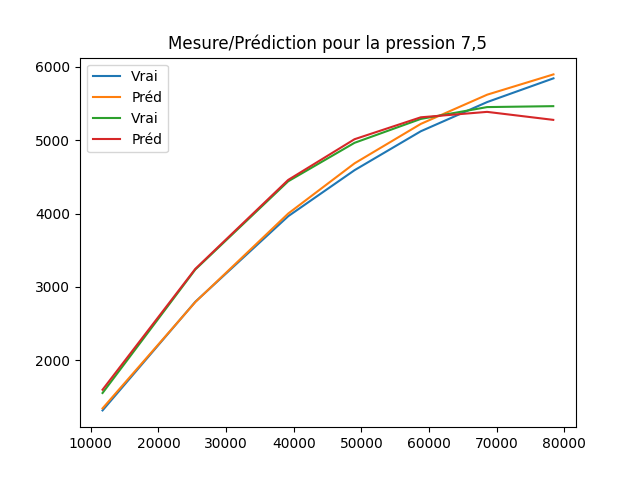

In [174]:
plt.plot(z3,dz3, label='Vrai')
plt.plot(z3,DZ3_pred_opt_bay_5,label='Préd')
plt.title("Mesure/Prédiction pour la pression 8,5 (LCB_100_100)")
plt.legend()
# Enregistrer la figure
plt.savefig("Mesure_Prédiction_Pression_8_5_Bay_5 (LCB_100_100)")

In [175]:
plt.close

<function matplotlib.pyplot.close(fig=None)>

## Conclusion

On peut conclure en disant que l'optimisation bayésienne est ausso compliquer car en fonction des paramètre 
on peut voir que les réusltat change 

Notre meilleur modèle c'est le 2 avec : 
result_2 = gp_minimize(wrapper, Bornes, acq_func='PI', n_calls=100, n_random_starts=50,random_state=42)

Mais l'optimisation et l'initialisation des paramètre en résolvant un système nous donnais néanmoins de meilleur résultat
mais c'étais un peu plus compliquer a trouver